Let's cluster the samples in the SwissProt GO dataset by their GO terms so we can use the cluster assignment to later do a stratified train/test split. We'll start by creating some embeddings for the terms.

/home/andrew/Workspace/AminoGOGO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finding dimensionality for All
Dimensionality: 1024, Explained Variance: 0.5857


Clustering All
Initialization 0
  Iteration 10	 time lapse 11.90688s	 ll change 9.42678
  Iteration 20	 time lapse 6.90108s	 ll change 3.82035
  Iteration 30	 time lapse 6.96210s	 ll change 1.87968
  Iteration 40	 time lapse 6.91941s	 ll change 0.09254
  Iteration 50	 time lapse 7.03263s	 ll change 0.05473
  Iteration 60	 time lapse 6.87167s	 ll change 0.80610
  Iteration 70	 time lapse 7.18097s	 ll change 6.35430
  Iteration 80	 time lapse 7.42114s	 ll change 0.06912
  Iteration 90	 time lapse 7.22328s	 ll change 0.01209
  Iteration 100	 time lapse 7.06025s	 ll change 0.10957
  Iteration 110	 time lapse 6.98064s	 ll change 0.01189
  Iteration 120	 time lapse 7.26755s	 ll change 0.01556
  Iteration 130	 time lapse 6.96495s	 ll change 0.00203
Initialization converged. time lapse 98.20569s	 lower bound 2423.76229.




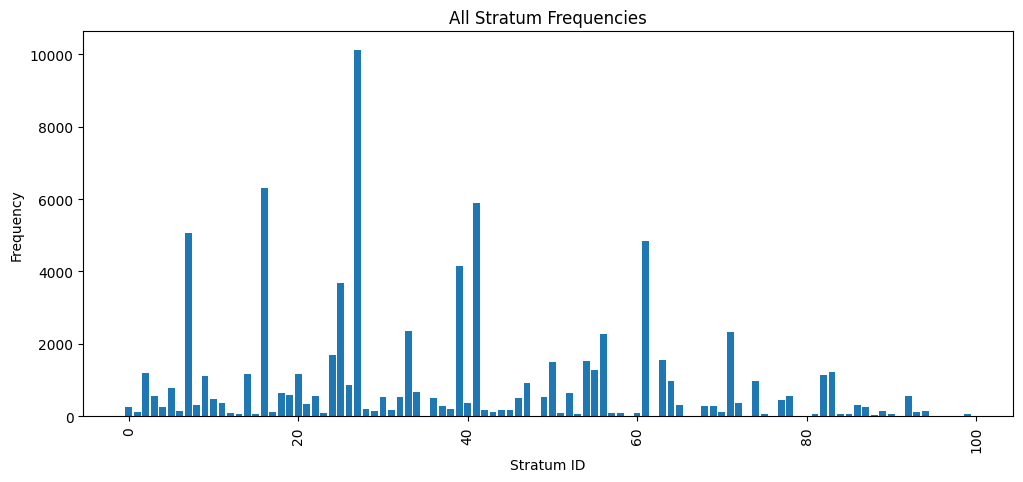



Finding dimensionality for Molecular Function
Dimensionality: 256, Explained Variance: 0.5587


Clustering Molecular Function
Initialization 0
  Iteration 10	 time lapse 2.89817s	 ll change 3.90719
  Iteration 20	 time lapse 2.13876s	 ll change 0.22275
  Iteration 30	 time lapse 2.18918s	 ll change 0.02412
Initialization converged. time lapse 7.65208s	 lower bound 820.82088.




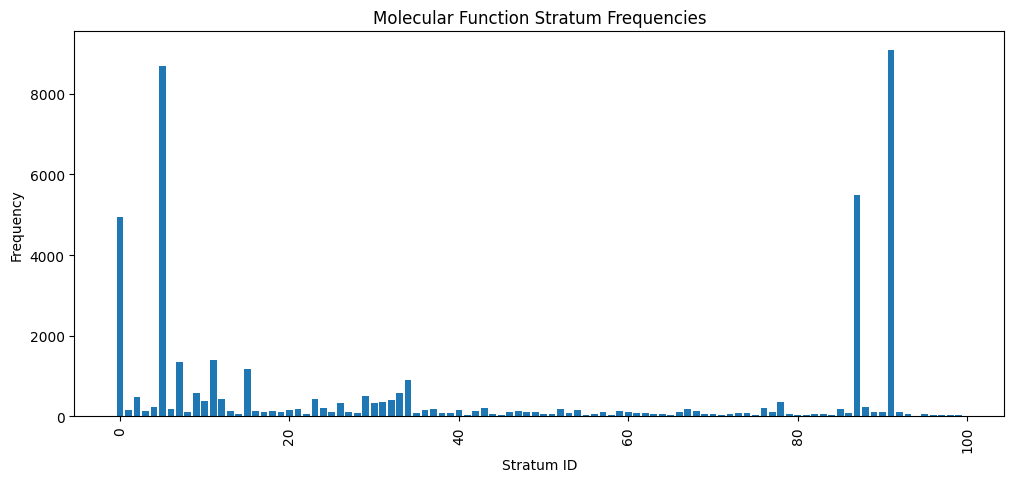



Finding dimensionality for Biological Process
Dimensionality: 1024, Explained Variance: 0.5435


Clustering Biological Process
Initialization 0
  Iteration 10	 time lapse 8.45126s	 ll change 11.36361
  Iteration 20	 time lapse 4.94921s	 ll change 5.26405
  Iteration 30	 time lapse 4.93500s	 ll change 0.30201
  Iteration 40	 time lapse 5.13311s	 ll change 0.06639
  Iteration 50	 time lapse 5.03500s	 ll change 0.00624
  Iteration 60	 time lapse 5.19248s	 ll change 0.00591
  Iteration 70	 time lapse 5.01444s	 ll change 3.71095
  Iteration 80	 time lapse 4.98843s	 ll change 0.68794
  Iteration 90	 time lapse 5.01487s	 ll change 0.00450
  Iteration 100	 time lapse 5.00758s	 ll change 0.00500
Initialization converged. time lapse 55.79614s	 lower bound 2648.71266.




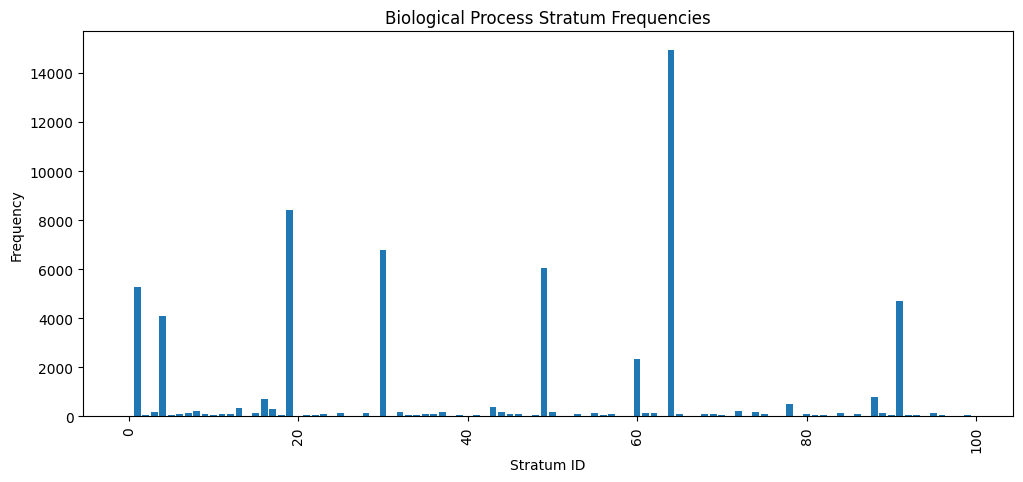



Finding dimensionality for Cellular Component
Dimensionality: 64, Explained Variance: 0.6523


Clustering Cellular Component
Initialization 0
  Iteration 10	 time lapse 2.30117s	 ll change 1.58832
  Iteration 20	 time lapse 2.01643s	 ll change 0.00885
Initialization converged. time lapse 5.72792s	 lower bound 204.79682.




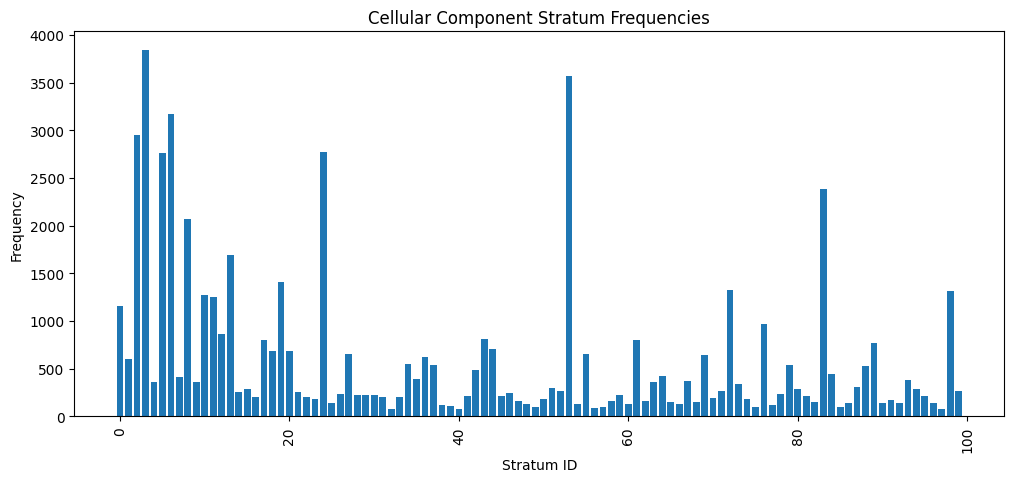

In [1]:
from functools import partial

from datasets import load_dataset

import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture

from collections import Counter

import matplotlib.pyplot as plt

all_dataset_path = "./dataset/all-expanded.jsonl"
mf_dataset_path = "./dataset/mf-expanded.jsonl"
bp_dataset_path = "./dataset/bp-expanded.jsonl"
cc_dataset_path = "./dataset/cc-expanded.jsonl"

num_strata = 100

min_explained_variance = 0.5

random_seed = 42

all_stratum_ids = {}
mf_stratum_ids = {}
bp_stratum_ids = {}
cc_stratum_ids = {}

new_svd = partial(TruncatedSVD, random_state=random_seed)

new_gmm = partial(
    GaussianMixture,
    n_components=100,
    covariance_type="spherical",
    random_state=random_seed,
    max_iter=200,
    verbose=2
)

all_counter = Counter()
mf_counter = Counter()
bp_counter = Counter()
cc_counter = Counter()

for name, dataset_path, stratum_ids, try_dimensions, counter in [
    ("All", all_dataset_path, all_stratum_ids, (1024, 2048, 4096), all_counter),
    ("Molecular Function", mf_dataset_path, mf_stratum_ids, (256, 512, 1024), mf_counter),
    ("Biological Process", bp_dataset_path, bp_stratum_ids, (1024, 2048, 4096), bp_counter),
    ("Cellular Component", cc_dataset_path, cc_stratum_ids, (64, 128, 256), cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    unique_terms = set()

    for record in dataset:
        for term in record["go_terms"]:
            unique_terms.add(term)

    term_index_mapping = {term: index for index, term in enumerate(unique_terms)}

    term_embeddings = {}

    for record in dataset:
        id = record["id"]

        embedding = np.zeros(len(term_index_mapping), dtype=np.int8)

        for term in record["go_terms"]:
            if term in term_index_mapping:
                index = term_index_mapping[term]

                embedding[index] = 1

        term_embeddings[id] = embedding

    print(f"Finding dimensionality for {name}")

    best_explained_variance = 0

    for dimensionality in try_dimensions:
        svd = new_svd(n_components=dimensionality)

        x = np.stack(list(term_embeddings.values()))
        
        svd.fit(x)
        
        explained_variance = np.sum(svd.explained_variance_ratio_)

        print(f"Dimensionality: {dimensionality}, Explained Variance: {explained_variance:.4f}")

        if explained_variance >= min_explained_variance:
            break

    z = svd.transform(x)

    for sequence_id, embedding in zip(term_embeddings.keys(), z):
        term_embeddings[sequence_id] = embedding

    print("\n")

    print(f"Clustering {name}")

    gmm = new_gmm()

    x = np.stack(list(term_embeddings.values()))

    predictions = gmm.fit_predict(x)

    for sequence_id, stratum_id in zip(term_embeddings.keys(), predictions):
        stratum_ids[sequence_id] = stratum_id

        counter[stratum_id] += 1

    print("\n")

    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"{name} Stratum Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Stratum ID")
    plt.ylabel("Frequency")

    plt.show()

    print("\n")

Lastly, add the term embeddings and stratum IDs to the dataset and write to disk.

In [2]:
import json

all_stratified_path = "./dataset/all-stratified.jsonl"
mf_stratified_path = "./dataset/mf-stratified.jsonl"
bp_stratified_path = "./dataset/bp-stratified.jsonl"
cc_stratified_path = "./dataset/cc-stratified.jsonl"

for dataset_path, stratified_path, stratum_ids, counter in [
    (all_dataset_path, all_stratified_path, all_stratum_ids, all_counter),
    (mf_dataset_path, mf_stratified_path, mf_stratum_ids, mf_counter),
    (bp_dataset_path, bp_stratified_path, bp_stratum_ids, bp_counter),
    (cc_dataset_path, cc_stratified_path, cc_stratum_ids, cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    dropped = 0

    with open(stratified_path, "w") as file:
        for record in dataset:
            id = record["id"]
            stratum_id = stratum_ids[id]

            if counter[stratum_id] < 2:
                dropped += 1

                continue

            record["stratum_id"] = str()

            file.write(json.dumps(record) + "\n")

    print(f"Dropped {dropped:,} noise samples from dataset.")

    print(f"Dataset saved to {stratified_path}")

print("Done!")

Dropped 11 noise samples from dataset.
Dataset saved to ./dataset/all-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/mf-stratified.jsonl
Dropped 18 noise samples from dataset.
Dataset saved to ./dataset/bp-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/cc-stratified.jsonl
Done!
